# Анализ спроса на самокаты

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, shapiro, mannwhitneyu, kruskal

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Предобработка данных о погоде

In [271]:
# Чтение данных и удаление первой строки с единицами измерения
df = pd.read_csv('weather.csv', na_values="", parse_dates=['Datetime']).drop(index=0, axis=1)

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.head()

datetime temperature precipitation_total wind_gust wind_speed  \
1 2023-04-01 00:00:00    8.740245                 0.1      48.6  21.638964   
2 2023-04-01 01:00:00    9.040245                 0.2     55.44  22.493519   
3 2023-04-01 02:00:00    8.880245                 0.3      55.8   22.26477   
4 2023-04-01 03:00:00    8.690246                 0.3     55.44   21.94524   
5 2023-04-01 04:00:00    8.630245                 0.3     48.96   22.42427   

  cloud_cover_total sunshine_duration  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0  
5                78                 0

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 1 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   object        
 2   precipitation_total  3642 non-null   object        
 3   wind_gust            3672 non-null   object        
 4   wind_speed           3656 non-null   object        
 5   cloud_cover_total    3652 non-null   object        
 6   sunshine_duration    3660 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 200.9+ KB


У всех столбцов, кроме даты, не верный тип данных

In [273]:
# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 1 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3617 non-null   float64       
 2   precipitation_total  3642 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3656 non-null   float64       
 5   cloud_cover_total    3652 non-null   float64       
 6   sunshine_duration    3660 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


### Проверка на дубликаты

In [274]:
# Проверим на дубликаты как полную строку, так и дату отдельно.
# Другие столбцы имеют право повторяться
df.duplicated().sum(), df['datetime'].duplicated().sum()

(np.int64(0), np.int64(0))

Дубликаты отсутствуют

### Работа с пропусками

In [275]:
df.isna().sum() # Проверка наличия пропусков

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Посмотрим на длины подряд идущих пропусков в столбцах, где они есть

In [276]:
na_lens = {}

for col in df.columns.drop(['datetime', 'wind_gust']):
        # Получаем длины подряд идущих пропусков
        lengths = (
            df[col].isna()
            .groupby(df[col].isna().ne(df[col].isna().shift()).cumsum())
            .sum()
        )

        # Добавляем в словарик сортированные длины
        na_lens[col] = sorted(lengths[lengths > 0].tolist())
    
na_lens

{'temperature': [3, 5, 6, 8, 10, 23],
 'precipitation_total': [3, 4, 9, 14],
 'wind_speed': [3, 4, 4, 5],
 'cloud_cover_total': [3, 3, 6, 8],
 'sunshine_duration': [3, 4, 5]}

Пропуски маленькой длины (<= 5) будем заполнять **интерполяцией**, т.к. за 5 часов погода изменится не сильно.<br>
Пропуски уже большой длины заполним с помощью **регрессии**

In [277]:
# Сортируем данные по дате
df = df.sort_values('datetime')

Найдем начальный и конечный индекс у каждой последовательности пропусков.<br>
Последовательность длиной <= 5 будем использовать для интерполяции, остальные для регрессии

In [278]:
interpolate_ranges = {} # Промежутки для интерполяции
regression_ranges = {} # Промежутки для регрессии

for col in df.columns.drop(['datetime', 'wind_gust']):
    # Получаем индексы пропусков для текущего столбца
    miss_indexes = df[col][df[col].isna()].index

    i_ranges, r_ranges = [], []
    start = None

    for i in range(len(miss_indexes)):
        if start is None:
            start = miss_indexes[i]
        
        # Проверяем, является ли текущий индекс частью подряд идущих пропусков
        if i == len(miss_indexes) - 1 or miss_indexes[i + 1] != miss_indexes[i] + 1:
            # Количество подряд идущих пропусков
            gap_length = miss_indexes[i] - start + 1
            
            if gap_length <= 5: # Интерполяция
                i_ranges.append((int(start), int(miss_indexes[i])))
            else: # Регрессия
                r_ranges.append((int(start), int(miss_indexes[i])))

            start = None

    if i_ranges: interpolate_ranges[col] = i_ranges
    if r_ranges: regression_ranges[col] = r_ranges

interpolate_ranges

{'temperature': [(1116, 1118), (2521, 2525)],
 'precipitation_total': [(1521, 1523), (2686, 2689)],
 'wind_speed': [(935, 938), (1296, 1300), (1921, 1923), (2185, 2188)],
 'cloud_cover_total': [(2573, 2575), (2790, 2792)],
 'sunshine_duration': [(1555, 1559), (1692, 1694), (2841, 2844)]}

In [257]:
regression_ranges

{'temperature': [(363, 372), (1006, 1013), (2506, 2511), (3054, 3076)],
 'precipitation_total': [(2403, 2411), (2716, 2729)],
 'cloud_cover_total': [(1694, 1699), (2053, 2060)]}

#### ДО ИНТЕРПОЛЯЦИИ

In [279]:
df.iloc[2518:2527]

datetime  temperature  precipitation_total  wind_gust  \
2519 2023-07-14 22:00:00    21.290245                  0.0  16.919998   
2520 2023-07-14 23:00:00    20.620245                  0.0  17.640000   
2521 2023-07-15 00:00:00          NaN                  0.0  17.640000   
2522 2023-07-15 01:00:00          NaN                  0.0  17.280000   
2523 2023-07-15 02:00:00          NaN                  0.0  16.919998   
2524 2023-07-15 03:00:00          NaN                  0.0  16.919998   
2525 2023-07-15 04:00:00          NaN                  0.0  16.919998   
2526 2023-07-15 05:00:00    19.320246                  0.0  17.640000   
2527 2023-07-15 06:00:00    22.450245                  0.0  18.359999   

      wind_speed  cloud_cover_total  sunshine_duration  
2519    4.735060                0.0           0.000000  
2520    4.802999                0.0           0.000000  
2521    5.014219               11.0           0.000000  
2522    4.829907               23.0           0.000000  
2523    5.191994               13.0           0.000000  
2524    5.991594               15.0           0.000000  
2525    5.804825                5.0          14.353199  
2526    6.915374                7.0          55.757576  
2527    5.860375               13.0          52.121212

In [280]:
# Используем интерполяцию
for col, ranges in interpolate_ranges.items():
    for r in ranges:
        # Т.к. интерполяция отталкивается от значений соседних точек, нужно сместить начальный и конечный индекс
        s, e = r[0] - 1, r[1] + 1 
        df.loc[s:e, col] = df.loc[s:e, col].interpolate()


#### ПОСЛЕ ИНТЕРПОЛЯЦИИ

In [281]:
df.iloc[2518:2527]

datetime  temperature  precipitation_total  wind_gust  \
2519 2023-07-14 22:00:00    21.290245                  0.0  16.919998   
2520 2023-07-14 23:00:00    20.620245                  0.0  17.640000   
2521 2023-07-15 00:00:00    20.403579                  0.0  17.640000   
2522 2023-07-15 01:00:00    20.186912                  0.0  17.280000   
2523 2023-07-15 02:00:00    19.970246                  0.0  16.919998   
2524 2023-07-15 03:00:00    19.753579                  0.0  16.919998   
2525 2023-07-15 04:00:00    19.536912                  0.0  16.919998   
2526 2023-07-15 05:00:00    19.320246                  0.0  17.640000   
2527 2023-07-15 06:00:00    22.450245                  0.0  18.359999   

      wind_speed  cloud_cover_total  sunshine_duration  
2519    4.735060                0.0           0.000000  
2520    4.802999                0.0           0.000000  
2521    5.014219               11.0           0.000000  
2522    4.829907               23.0           0.000000  
2523    5.191994               13.0           0.000000  
2524    5.991594               15.0           0.000000  
2525    5.804825                5.0          14.353199  
2526    6.915374                7.0          55.757576  
2527    5.860375               13.0          52.121212

#### ДО РЕГРЕССИИ

In [282]:
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00          NaN                  0.0  12.959999   
1007 2023-05-12 22:00:00          NaN                  0.0  14.040000   
1008 2023-05-12 23:00:00          NaN                  0.0  14.040000   
1009 2023-05-13 00:00:00          NaN                  0.0  13.679999   
1010 2023-05-13 01:00:00          NaN                  0.0  12.959999   
1011 2023-05-13 02:00:00          NaN                  0.0  12.599999   
1012 2023-05-13 03:00:00          NaN                  0.0  11.159999   
1013 2023-05-13 04:00:00          NaN                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

In [283]:
for col in regression_ranges:
    train_df = df.dropna() # Убираем пропуски для обучения модели
    
    X = train_df.drop(columns=[col, 'datetime']) # Признаки 
    y = train_df[col] # Целевая переменная

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.33, random_state=42)

    # Создаем и обучаем модель линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)

    test_df = df[df[col].isna()]  # Данные с пропусками в целевой переменной
    X_test = test_df.drop(columns=[col, 'datetime'])  # Признаки для предсказания
    predictions = model.predict(X_test)

    # Заполняем пропуски в целевой переменной
    df.loc[df[col].isna(), col] = predictions

#### ПОСЛЕ РЕГРЕССИИ

In [284]:
df.iloc[1004:1014]

datetime  temperature  precipitation_total  wind_gust  \
1005 2023-05-12 20:00:00    13.690246                  0.0  14.400000   
1006 2023-05-12 21:00:00    14.396316                  0.0  12.959999   
1007 2023-05-12 22:00:00    13.863751                  0.0  14.040000   
1008 2023-05-12 23:00:00    14.159264                  0.0  14.040000   
1009 2023-05-13 00:00:00    13.898614                  0.0  13.679999   
1010 2023-05-13 01:00:00    14.009935                  0.0  12.959999   
1011 2023-05-13 02:00:00    13.279870                  0.0  12.599999   
1012 2023-05-13 03:00:00    12.784216                  0.0  11.159999   
1013 2023-05-13 04:00:00    12.413884                  0.0  10.799999   
1014 2023-05-13 05:00:00    11.870245                  0.0  11.520000   

      wind_speed  cloud_cover_total  sunshine_duration  
1005    5.506941               26.0           0.000000  
1006    6.569383               20.0           0.000000  
1007    7.244860               38.0           0.000000  
1008    6.618519               38.0           0.000000  
1009    7.729527               25.0           0.000000  
1010    7.172949               23.7           0.000000  
1011    8.557102               23.1           0.000000  
1012    6.725354               59.0           0.000000  
1013    6.638072               77.0           1.440741  
1014    6.877790               91.0           4.848486

Проверим работу

In [285]:
df.isna().sum()

datetime               0
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64

### Проверка на выбросы

In [288]:
df.describe().round(2)

datetime  temperature  precipitation_total  \
count                           3672      3672.00              3672.00   
mean   2023-06-16 11:30:00.000000256        18.12                 0.10   
min              2023-04-01 00:00:00        -2.08                -0.02   
25%              2023-05-09 05:45:00        13.30                 0.00   
50%              2023-06-16 11:30:00        18.04                 0.00   
75%              2023-07-24 17:15:00        22.95                 0.00   
max              2023-08-31 23:00:00        36.15                 5.80   
std                              NaN         6.81                 0.34   

       wind_gust  wind_speed  cloud_cover_total  sunshine_duration  
count    3672.00     3672.00            3672.00            3672.00  
mean       20.89        7.35              40.97              21.54  
min         2.88        0.00              -2.85               0.00  
25%        13.32        4.33              15.00               0.00  
50%        18.36        6.29              32.00              15.15  
75%        26.28        9.47              67.00              42.55  
max        71.28       29.97             100.00              60.00  
std        10.44        4.26              31.32              21.88

Все значения находятся в норме, выбросов не наблюдается

### Выгрузка новой таблицы

In [289]:
# Добавляем единицы измерения в начало таблицы
units_of_measure = ["", "°C", "mm", "km/h", "km/h", "%", "min"]
first_row = pd.DataFrame([units_of_measure], columns=df.columns, index=[0]) 
df = pd.concat([first_row, df], ignore_index=True)

df.to_csv('processed_weather.csv', index=False)

## Предобработка данных о поездках

In [36]:
# Чтение данных
df = pd.read_csv('rides.csv', na_values="", parse_dates=['Start Date', 'End Date'])

# Названия колонок к PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()
    
# Приводим значения направлений движения к единому формату
df['end_district'] = df['end_district'].str.lower().str.strip().str.replace(" ", '-')
df['start_district'] = df['start_district'].str.lower().str.strip().str.replace(" ", '-')

# Приводим значения начальных и конечных точек к единому формату
df['start_location'] = df['start_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['start_location'] = df['start_location'].str.replace('ул ', '')

df['end_location'] = df['end_location'].str.lower().str.strip().str.replace(".", ' ').str.replace("  ", ' ')
df['end_location'] = df['end_location'].str.replace('ул ', '')

### Проверка на дубликаты

In [37]:
df.duplicated().sum()

np.int64(4883)

Данные, представленные в таблице rides.csv не должны дублироваться, поэтому удаляем дубликаты

In [38]:
# Удаляем дубликаты и обновляем индексацию
df = df.drop_duplicates()
df = df.reset_index(drop=True)

### Работа с пропусками

In [39]:
df.isna().sum() # Проверка наличия пропусков

id                   0
start_date           0
end_date           555
start_location       0
start_district       0
end_location         0
end_district         0
distance          1181
promo                0
dtype: int64

Наблюдаются пропуски с дате окончания поездки и дистанции поездки.

* Пропуски в end_date будем заполнять на основании пройденной дистанции

* Пропуски в distance будем заполнять на основании времени поездки

#### Работа с пропусками в end_date

Рассчитывать время конца поездки будем на основании медианы средней скорости во время пути и дистанции поездки.

Формула: Конец_поездки = начало_поездки + (дистанция / медиана_средней_скорости)

##### ДО

In [40]:
df.iloc[946:949]

id          start_date            end_date start_location  \
946  101286 2023-04-22 23:33:50                 NaT         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03         кирова   

    start_district end_location end_district  distance  promo  
946       заречный  октябрьская     заречный    2521.0      0  
947    центральный     суворова    ленинский    3204.0      0  
948      ленинский    буденного  октябрьский    3755.0      0

##### ПОСЛЕ

In [45]:
# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = (df.end_date - df.start_date).dt.seconds / 60 

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = (df.distance / 1000) / (df.ride_duration / 60)

median_average_speed = df['average_speed'].median()

# Заполнение пустых значений в столбце 'end_date'
df['end_date'] = df['end_date'].fillna(
    df['start_date'] + pd.to_timedelta((df['distance'] / 1000) / median_average_speed, unit='h')
)

df.iloc[946:949]

id          start_date                      end_date start_location  \
946  101286 2023-04-22 23:33:50 2023-04-22 23:50:25.672184098         чехова   
947  101287 2023-04-22 23:35:04 2023-04-22 23:54:26.000000000      советская   
948  101288 2023-04-22 23:36:43 2023-04-23 00:14:03.000000000         кирова   

    start_district end_location end_district  distance  promo  ride_duration  \
946       заречный  октябрьская     заречный    2521.0      0      16.583333   
947    центральный     суворова    ленинский    3204.0      0      19.366667   
948      ленинский    буденного  октябрьский    3755.0      0      37.333333   

     average_speed  
946       9.121206  
947       9.926334  
948       6.034821

#### Работа с пропусками в distance

Рассчитывать дистанцию поездки будем на основании медианы средней скорости во время пути и длительности поездки.

Формула: Дистанция = медиана_средней_скорости * время_поездки

##### ДО

In [93]:
df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district  distance  promo  \
1130  юго-восточный   пионерская       заречный       NaN      0   
1131      ленинский       дружбы    центральный    3581.0      0   
1132    октябрьский   молодежная  юго-восточный    3082.0      0   

      ride_duration  average_speed  
1130      44.366667            NaN  
1131      19.666667      10.925085  
1132      21.783333       8.489059

##### ПОСЛЕ

In [94]:
# Заполнение пустых значений в столбце 'distance'
df['distance'] = df['distance'].fillna(median_average_speed * (df['ride_duration'] / 60) * 1000)

df.iloc[1130:1133]

id          start_date            end_date start_location  \
1130  101470 2023-04-23 11:26:28 2023-04-23 12:10:50         речная   
1131  101471 2023-04-23 11:27:21 2023-04-23 11:47:01       комарова   
1132  101472 2023-04-23 11:28:32 2023-04-23 11:50:19        майская   

     start_district end_location   end_district    distance  promo  \
1130  юго-восточный   пионерская       заречный  6740.07179      0   
1131      ленинский       дружбы    центральный  3581.00000      0   
1132    октябрьский   молодежная  юго-восточный  3082.00000      0   

      ride_duration  average_speed  
1130      44.366667            NaN  
1131      19.666667      10.925085  
1132      21.783333       8.489059

#### Проверка работы

In [95]:
df = df.drop(['ride_duration', 'average_speed'], axis=1) # Удаляем уже ненужные стоблцы

df.isna().sum() # Проверка наличия пропусков

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### Проверка на выбросы

In [96]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

id                     start_date                       end_date  \
count  97372.00                          97372                          97372   
mean  149025.50  2023-06-13 21:06:08.931407360  2023-06-13 21:33:03.576468480   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124682.75     2023-05-20 21:41:39.500000            2023-05-20 22:07:59   
50%   149025.50            2023-06-14 15:15:46            2023-06-14 15:44:53   
75%   173368.25  2023-07-08 19:50:22.249999872            2023-07-08 20:18:30   
max   197711.00            2023-07-31 23:57:01  2023-08-14 07:25:37.719536260   
std    28109.02                            NaN                            NaN   

        distance    promo  
count   97372.00 97372.00  
mean    26998.68     0.02  
min         1.00     0.00  
25%      3044.00     0.00  
50%      3703.00     0.00  
75%      4433.00     0.00  
max   7569789.00     1.00  
std    307435.12     0.14

В distance присутствуют очень сильные выбросы, вероятно, они вызваны ошибками в показаниях датчиков

Так как выбросы в distance аномально большие или маленькие, то самым простым способом будет вручную отфильтровать выбросы и исправить ошибочные значения, не прибегая к интерквартильному размаху или стандартным отклонениям

Выбросы будем исправлять по аналогии с пропусками.

Некоторые строки с выбросами также содержали пустые данные и на этапе заполнения пустых данных, заполненные пропуски тоже получили некорректные значения. При условии, что один из параметров выброс, а другой был пропущен - мы не можем восстановить данные, следовательно придется их удалить.

In [97]:
# Обновляем значения в колонке ride_duration
df['ride_duration'] = (df.end_date - df.start_date).seconds / 60

# Удаляем значения, которые невозможно восстановить и обновляем индексацию
df = df[(df['ride_duration'] < 90) & (df['ride_duration'] > 10)]
df = df.reset_index(drop=True)

##### ДО

In [98]:
df.iloc[954:957]

id          start_date            end_date start_location  \
954  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   
955  101300 2023-04-22 23:58:02 2023-04-23 00:20:51       заречная   
956  101301 2023-04-22 23:58:44 2023-04-23 00:22:00      подгорная   

    start_district end_location   end_district   distance  promo  \
954    центральный      свободы      ленинский 4273850.00      0   
955  юго-восточный   спортивная    октябрьский    3186.00      0   
956      ленинский      озерная  юго-восточный    4679.00      0   

     ride_duration  
954          29.32  
955          22.82  
956          23.27

##### ПОСЛЕ

In [99]:
# Заменяем выбросы в соответствии с формулой
df['distance'] = df['distance'].where(
    (df['distance'] >= 10) & (df['distance'] <= 50000), 
    median_average_speed * (df['ride_duration'] / 60) * 1000
).round().astype(int)

df.iloc[954:957]

id          start_date            end_date start_location  \
954  101299 2023-04-22 23:54:39 2023-04-23 00:23:58         дачная   
955  101300 2023-04-22 23:58:02 2023-04-23 00:20:51       заречная   
956  101301 2023-04-22 23:58:44 2023-04-23 00:22:00      подгорная   

    start_district end_location   end_district  distance  promo  ride_duration  
954    центральный      свободы      ленинский      4454      0          29.32  
955  юго-восточный   спортивная    октябрьский      3186      0          22.82  
956      ленинский      озерная  юго-восточный      4679      0          23.27

#### Проверка работы

In [100]:
# Удаляем теперь ненужные колонны таблицы
df = df.drop(['ride_duration'], axis=1) 

df.describe()

id                     start_date                       end_date  \
count  96638.00                          96638                          96638   
mean  149020.97  2023-06-13 20:58:56.413264128  2023-06-13 21:25:26.435115264   
min   100340.00            2023-04-22 09:01:03            2023-04-22 09:24:45   
25%   124672.25  2023-05-20 21:32:31.750000128            2023-05-20 21:58:06   
50%   149018.50            2023-06-14 15:08:45     2023-06-14 15:37:43.500000   
75%   173376.75     2023-07-08 19:55:47.500000     2023-07-08 20:21:19.500000   
max   197711.00            2023-07-31 23:57:01            2023-08-01 00:42:12   
std    28113.79                            NaN                            NaN   

       distance    promo  
count  96638.00 96638.00  
mean    3845.82     0.02  
min     1094.00     0.00  
25%     3119.00     0.00  
50%     3743.00     0.00  
75%     4456.00     0.00  
max    12675.00     1.00  
std     1036.42     0.14

### Выгрузка новой таблицы

In [101]:
# Приводим дистанцию к целочисленному типу
df['distance'] = df['distance'].astype(int)

df.to_csv('processed_rides.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

## Объединение таблиц

Для более удобного анализа данных стоит объединить имеющиеся таблицы

In [102]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

rides_df['rounded_start_time'] = rides_df['start_date'].dt.round('h')


merge_df = pd.merge_asof(
    rides_df.sort_values('rounded_start_time'), 
    weather_df.sort_values('datetime'), 
    left_on='rounded_start_time', 
    right_on='datetime', 
    direction='backward'
)

merge_df = merge_df.drop('rounded_start_time', axis=1)

merge_df.to_csv('rides_&_weather.csv', index=False)

## Проведение расчетов и исследований

### 1. Расчет итоговой стоимости

Формула итоговой стоимость:

![alt text](image.png)

Тарифный план:

![alt text](img.png)


Рассчитаем итоговую стоимость и проверим как доход распределены по часам

#### Расчёты

Сначала создадим универсальную функцию, в которую мы передаём датафрейм, а она возвращает новый датафрейм с рассчитанным доходом(новая колонка price)

In [53]:
def calculate_income(df: pd.DataFrame) -> pd.DataFrame:
    # Функция для определения стоимости за минуту
    def calculate_price(row):
        day_of_week = row['start_date'].day_name()
        start_hour = row['start_date'].hour
        
        if 1 <= start_hour < 6:
            return 3
        if 6 <= start_hour < 10:
                return 4

        if day_of_week in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
            if 10 <= start_hour < 16:
                return 5
            elif 16 <= start_hour < 22:
                return 6
            else:
                return 5
        if day_of_week in ['Sunday', 'Saturday']:
            if 10 <= start_hour < 16:
                return 6
            elif 16 <= start_hour < 22:
                return 7
            else:
                return 6


    df = df.copy()
    
    # Рассчитываем стоимость за минуту для каждой строки
    df['price_per_minute'] = df.apply(calculate_price, axis=1)

    # Рассчитываем доход
    df['duration_minutes'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 60
    df['price'] = df['price_per_minute'] * df['duration_minutes']
    
    # Удаяем теперь ненужные колонки
    df = df.drop(['price_per_minute', 'duration_minutes'], axis=1)

    return df

Теперь проведём основные расчёты

In [54]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем доход за каждую поездку
df = calculate_income(df)

# Оставляем только временной промежуток, к которому принадлежит стоимость и стоимость
hour_df = df[['price', 'datetime']]
hour_df['datetime'] = hour_df['datetime'].dt.hour

# Группируем по часам и считаем общий и средний доход
sum_price_df = hour_df.groupby(by=['datetime']).sum()
mean_price_df = hour_df.groupby(by=['datetime'])['price'].mean()

# Группируем по дням недели
day_df = df
day_df['datetime'] = pd.to_datetime(day_df['datetime'])
day_df['day'] = day_df['datetime'].dt.day_name()

#### Визуализация

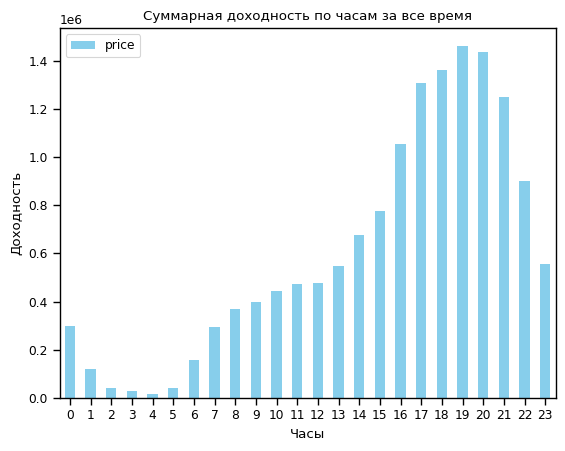

In [55]:
sum_price_df.plot(kind='bar', color='skyblue')
plt.title('Суммарная доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Доходность')
plt.xticks(rotation=0)
plt.show()

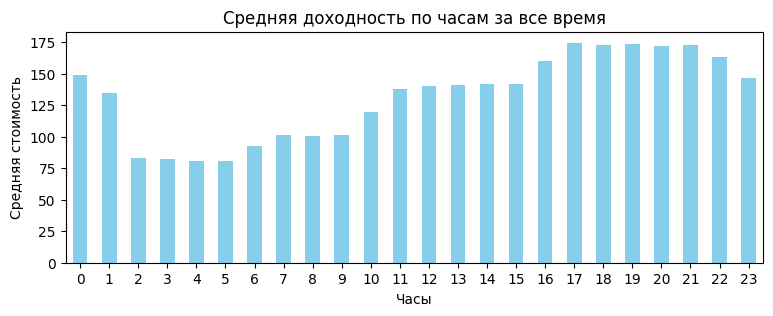

In [24]:
plt.figure(figsize=(9, 3))
mean_price_df.plot(kind='bar', color='skyblue')
plt.title('Средняя доходность по часам за все время')
plt.xlabel('Часы')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=0)
plt.show()


#### Вывод

На основе графического анализа можно сделать следующие выводы:
* Самый большие доходы компания получает с 17:00 и до 21:00. Это логично, тогда самый высокий тариф.
* Самые маленькие доходы компания получает с 2:00 до 5:00. Это логично, так как в это время все спят и в это время самый низкий спрос.
* Доходы с самокатов утром меньше, чем вечером. Это логично, так как тариф в это время в 2 раза меньше.
* Средняя стоимость поездки выше всего после конца рабочего дня. Это логично, тогда самый высокий тариф.
* Средняя стоимость поездки ниже всего ночью. Это логично, так как в это время все спят и в это время самый низкий спрос.

### 2. Стимулирует ли акция спрос на самокаты?

#### Подготовка данных

Так как акция проводится только по понедельникам с 6 до 10. То для анализа стоит брать дни недели, который будут статистически похожи на понедельник. Ближе всего к понедельнику оказалась пятница, но для анализа мы так же дополнительно возьмем вторник, среду и четверг.

In [122]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Берём только поездки с 6 до 10
df = df[(df['start_date'].dt.hour >= 6) & (df['start_date'].dt.hour <= 9)]

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

#### Корреляционный анализ

Мы проверим 2 корреляции: 

1. Зависит ли спрос по утрам от дня недели.
2. Зависит ли спрос по утрам(будем брать данные с пятницы и понедельника) от проведения акции.

Так как в исследованиях, которые проводились до этого, выяснилось, что данные по спросу(поездкам) распределены ненормально, то при расчёте корреляции мы будет использовать критерии Манна-Уитни и Краскела-Уоллеса

##### Зависит ли спрос по утрам по дня недели.

In [123]:
# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

# Тест Манна-Уитни
stat, p_value = kruskal(*grouped_data)

print(p_value < 0.05)


True


Так как p_value < 0.05, то спрос по утрам действительно зависит от дня недели

##### Зависит ли спрос по утрам от проведения акции.

In [180]:
# Группировка данных по наличию акции
monday_friday_df = df[(df['day'] == 'Monday') | (df['day'] == 'Friday')]

promo_group = monday_friday_df[monday_friday_df['promo'] == 1]  
no_promo_group = monday_friday_df[monday_friday_df['promo'] == 0]

# Тест Манна-Уитни
stat, p_value = mannwhitneyu(promo_group['id'], no_promo_group['id'])

print(p_value < 0.05)

True


Так как p_value < 0.05, то спрос по утрам действительно зависит от проведения акции

#### Графический анализ

Сначала сравним понедельник с другими днями

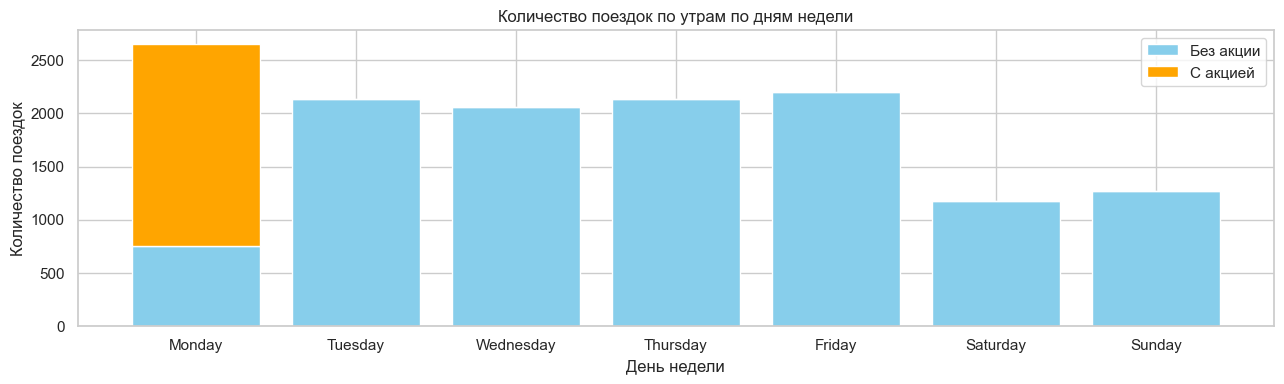

In [125]:
# Группировка данных по наличию акции и дню недели
grouped_data = df.groupby(['day', 'promo']).size().unstack(fill_value=0)

# Переупорядочивание индексов для правильного отображения
grouped_data = grouped_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Построение бар-графика
plt.figure(figsize=(13, 4))
bars = plt.bar(grouped_data.index, grouped_data[0], color='skyblue', label='Без акции')  # Поездки без акции
bars2 = plt.bar(grouped_data.index, grouped_data[1], bottom=grouped_data[0], color='orange', label='С акцией')  # Поездки с акцией
plt.title('Количество поездок по утрам по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Графически видно, что в понедельник спрос действительно гораздо больше и около 70% людей воспользовались акцией

А теперь сравним трафик по часам в понедельник с 6 до 10 с остальными днями

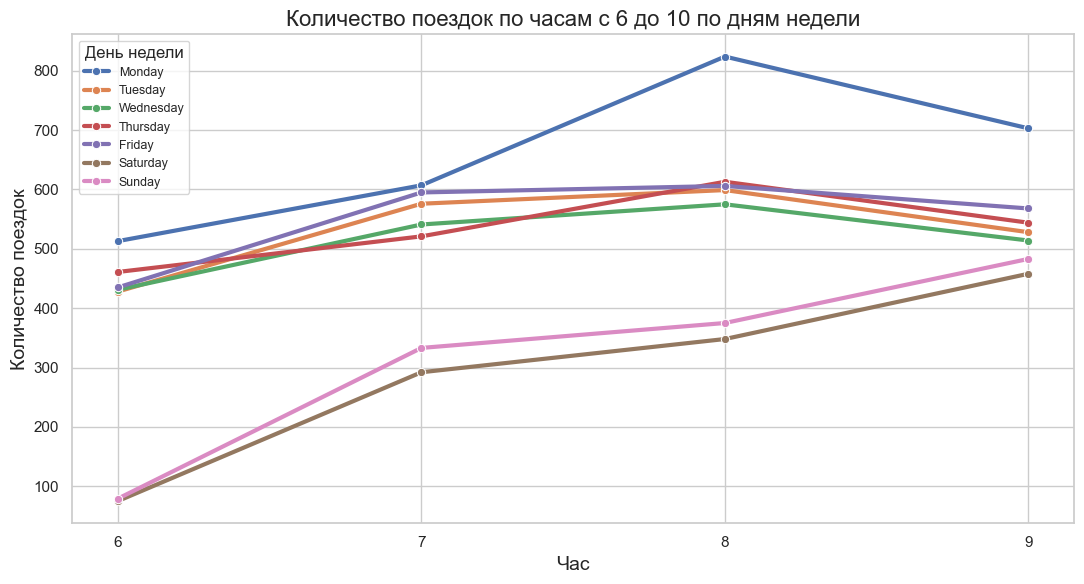

In [127]:
# Создание нового DataFrame для группировки по часам и дням недели
df['hour'] = df['start_date'].dt.hour
hourly_data = df.groupby(['day', 'hour']).size().reset_index(name='traffic')

# Переупорядочивание индексов для правильного отображения
hourly_data['day'] = pd.Categorical(hourly_data['day'], 
                                     categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                     ordered=True)

# Построение графика
plt.figure(figsize=(11, 6))
sns.lineplot(data=hourly_data, x='hour', y='traffic', hue='day', marker='o', lw=3)
plt.title('Количество поездок по часам с 6 до 10 по дням недели', fontsize=16)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.xticks(hourly_data['hour'].unique())
plt.legend(title='День недели', fontsize=9)
plt.tight_layout()
plt.show()


Трафик в понедельник сопоставим со трафиком в будние дни с 6:00 до 7:00, но с 8:00 до 10:00 наблюдается значительный рост

Дополнительно проверим % людей, которые ездят по акции в понедельник по часам

In [174]:
# Берём только данные по понедельникам
monday_df = df[(df['start_date'].dt.day_name() == 'Monday')]

# Группировка по часам и наличию акции
traffic_counts = monday_df.groupby(['hour', 'promo']).size().unstack(fill_value=0)

# Рассчет общего количества поездок по часам
traffic_counts['total'] = traffic_counts.sum(axis=1)

# Рассчет процента поездок с акцией
traffic_counts['promotion_percentage'] = (traffic_counts[True] / traffic_counts['total']) * 100

# Теперь percentage_data содержит только 'hour' и 'promotion_percentage'
for elem in traffic_counts.reset_index().values:
    print(f'{int(elem[0])}:00 - {round(elem[-1], 1)} %')

6:00 - 71.0 %
7:00 - 73.3 %
8:00 - 69.5 %
9:00 - 72.4 %


Процент людей в среднем всегда равен 70%, значит акция всегда равномерно эффективна и нет смысла её отменять или переносить на другое время.

#### Вывод

На основании проведенного исследования можно сказать, что: 
* Акция действительно стимулирует спрос
* Самый высокий спрос в день проведения акции(понедельник), а самый низкий по выходным
* Спрос на самокаты утром действительно зависит от дня недели

### 3. Исследование корреляцию между параметрами погодных условий

#### Первичный анализ

Перед началом исследования стоит понять как распределены данные, чтобы выбрать правильный коэффицент. Будем использовать тест Шапиро-Уилка и графический анализ.

temperature  -  0.0
precipitation_total  -  0.0
wind_gust  -  0.0
wind_speed  -  0.0
cloud_cover_total  -  0.0
sunshine_duration  -  0.0


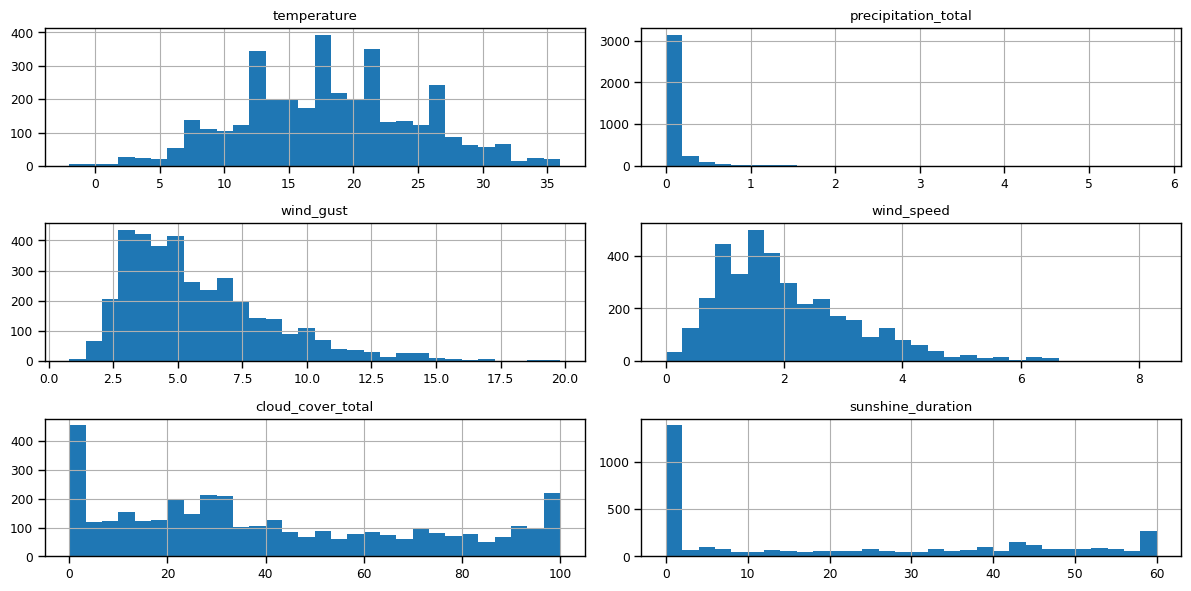

In [26]:
df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Приведение колонок к float, кроме колонки с датами
for col in df.columns[1:]:
    df[col] = df[col].astype(float)

# Проверяем данные через тест Шапиро-Уилка
for col in df.columns[1:]:
    stat, p_value = shapiro(df[col])  
    print(col, ' - ', p_value.round(5))

# Строим график
df.drop('datetime', axis=1).hist(bins=30, figsize=(12, 6))
plt.tight_layout()
plt.show()

По данным из теста Шапиро-Уилка и из графиков можно сделать вывод, что все данные распределены ненормально, следовательно, так как все данные количественные, то будет использовать коэффицент Спирмена для поиска корреляций. 

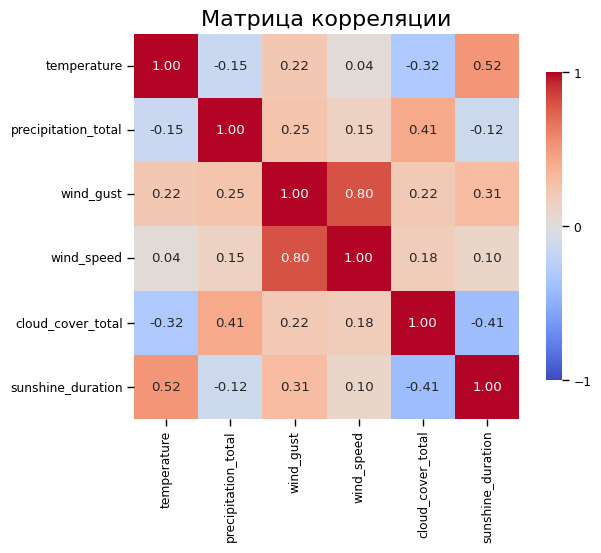

In [27]:
# Так как в исследледовании мы исследуем только параметры погодных условий, то удаляем datetime
df = df.drop('datetime', axis=1)

# Строим матрицу корреляций
corr_df = df.corr(method='spearman')

# Настройка графика
plt.figure(figsize=(7, 5))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8, "ticks": [-1, 0, 1]}, vmin=-1, vmax=1)
plt.title('Матрица корреляции', fontsize=16)
plt.show()

Исследуем данные, где корреляционное значение больше 0.3 или меньше < -0.3, то есть данные, как минимум с умеренной корреляцией.

Нам подходят следующие корреляции:

* Умеренные
    1. Облачность и температура (Обратная зависимость)
    2. Облачность и общее количество осадков
    3. Порывы ветра и продолжительность солнечного сияния 
    4. Продолжительность солнечного сияния и облачность (Обратная зависимость)
* Заметная
    1. Продолжительность солнечного сияния и температура
* Высокая
    1. Скорость ветра и порывы ветра

#### Умеренные

##### 1. Облачность и температура

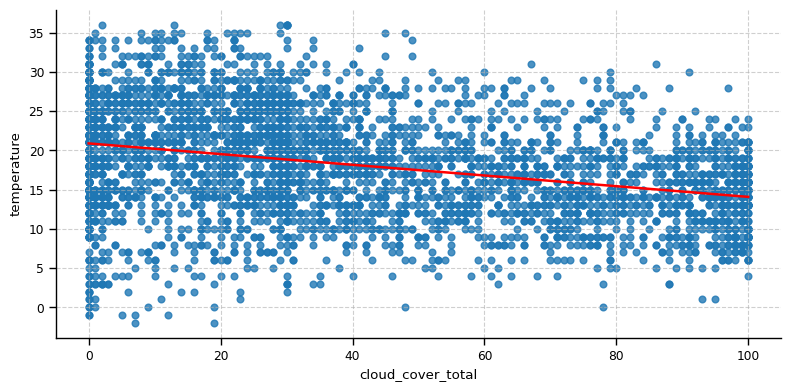

In [28]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="temperature", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная обратная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли и нагревают её, следовательно температура падает.

То есть можно сделать вывод, что облачность выступает как ограничивающий фактор для связи между продолжительностью солнечного сияния и температурой, смягчая их влияние. При высокой облачности воздействие солнечного сияния на температуру становится менее выраженным, но корреляция между солнечным сиянием и температурой остается значимой.

##### 2. Облачность и общее количество осадков

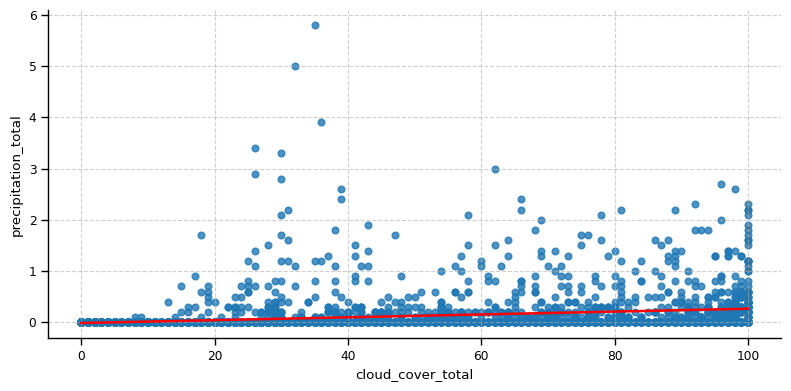

In [29]:
sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="precipitation_total", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается умеренная корреляция между факторами. Её легко объяснить. Когда на небе много облаков, то, вероятно и погода хуже, а следовательно вероятность дождя выше.

То есть можно сделать вывод, что облачность выступает как основной фактор, влияющий на количество осадков.

##### 3. Порывы ветра и продолжительность солнечного сияния 

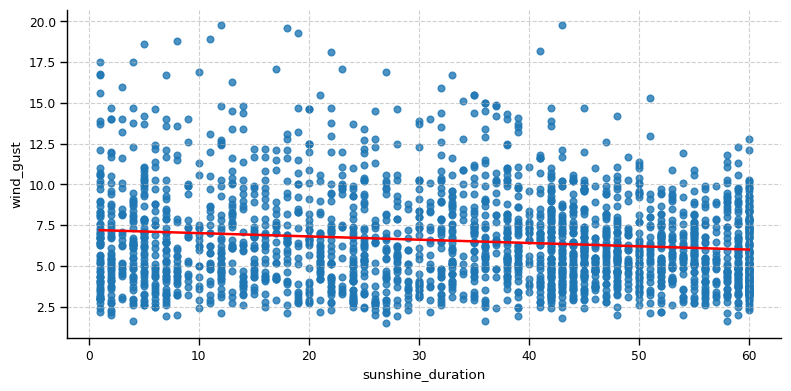

In [34]:
# Берём только время, когда светит солнце
sunshine_df = df[df['sunshine_duration'] > 0]

sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="wind_gust", data=sunshine_df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается слабая умеренная корреляция между факторами. Её так легко объяснить. Вероятно, при появлении воздушных масс, блокирующих солнечные лучи, порывы ветра их сгоняют.

То есть можно сделать вывод, что связь между этими факторами является особенностью представленных данных и выступает как бы случайным "шумом".

##### 4. Продолжительность солнечного сияния и облачность 

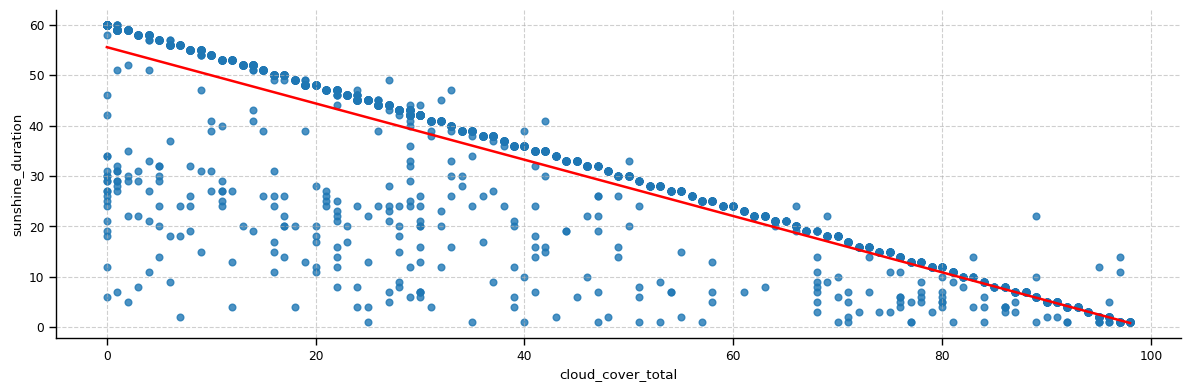

In [31]:
# Берём только время, когда светит солнце
sunshine_df = df[df['sunshine_duration'] > 0]

sns.set_context("paper")
sns.lmplot(x="cloud_cover_total", y="sunshine_duration", data=sunshine_df, ci=None, aspect=3, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается умеренная обратная корреляция между факторами. Её легко можно объяснить. Когда на небе много облаков, то лучи солнца хуже доходят до земли.

То есть можно сделать вывод, что облачность выступает как основной фактор от которого зависит продолжительность солнечного сияния. Данный вывод подкрепляет вывод из первого пункта(1. Облачность и температрура).

#### Заметные

##### 1. Продолжительность солнечного сияния и температура

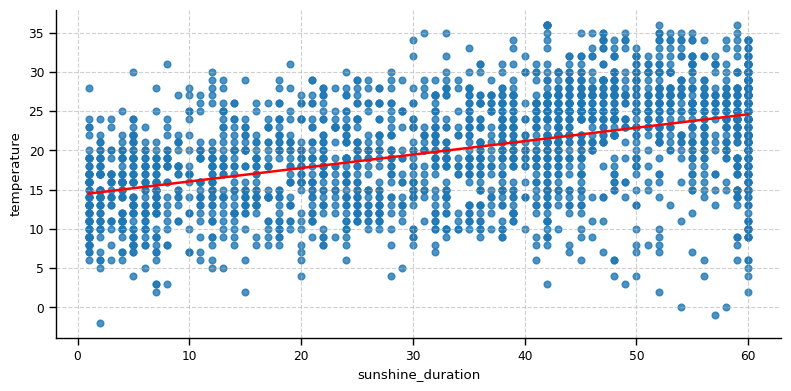

In [35]:
# Берём только время, когда светит солнце
sunshine_df = df[df['sunshine_duration'] > 0]

sns.set_context("paper")
sns.lmplot(x="sunshine_duration", y="temperature", data=sunshine_df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается заметная корреляция между факторами. Её легко можно объяснить. Чем дольше солнце светит и ему ничего не мешает, то тем сильнее нагревается Земля и растет температура.

То есть можно сделать вывод, что продолжительность солнечного сияния выступает как основной фактор от которого зависит температура.

#### Высокие

##### 1. Скорость ветра и порывы ветра

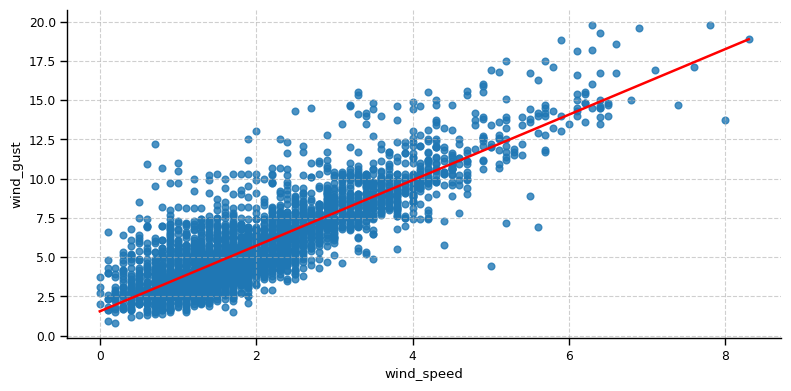

In [15]:
sns.set_context("paper")
sns.lmplot(x="wind_speed", y="wind_gust", data=df, ci=None, aspect=2, height=4, line_kws={'color': 'red'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Судя по значению корреляции и графическому анализу, наблюдается высокая корреляция между факторами. Её легко можно объяснить. Чем выше скорость ветка, тем соответственно и ветреннее погода, следовательно и больше скорость порывов ветра.

То есть можно сделать вывод, что скорость ветра выступает как основной фактор от которого зависит скорость порывов ветра.

#### Вывод

На основе проведенного исследования можно сделать следующие выводы:

- Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
- Общее количество осадков зависит больше всего от облачности.
- Скорость порывов ветра почти полностью зависят от скорости ветра.

### 4. Подготовка таблицы с почасовым трафиком в каждой точке. 


#### Создание таблицы

In [301]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])

In [307]:
arrivals = (df.groupby(['end_location', df['end_date'].dt.floor('h')])
            .size()
            .reset_index(name='arrivals'))

departures = (df.groupby(['start_location', df['start_date'].dt.floor('h')])
              .size()
              .reset_index(name='departures'))

arrivals.rename(columns={'end_location': 'location', 'end_date': 'date'}, inplace=True)
departures.rename(columns={'start_location': 'location', 'start_date': 'date'}, inplace=True)

# Объединение данных по локации и времени
traffic_by_hours = pd.merge(arrivals, departures, on=['location', 'date'], how='outer').fillna(0)

# Считаем общий трафик
traffic_by_hours['total'] = traffic_by_hours['arrivals'] + traffic_by_hours['departures']

# Колонка - месяц
traffic_by_hours['month'] = traffic_by_hours['date'].dt.month_name(locale='ru')

# Установка даты как индекс
traffic_by_hours.set_index('date', inplace=True)

traffic_by_hours.head()


location  arrivals  departures  total   month
date                                                               
2023-04-22 10:00:00  береговая       1.0         0.0    1.0  Апрель
2023-04-22 13:00:00  береговая       0.0         1.0    1.0  Апрель
2023-04-22 14:00:00  береговая       0.0         2.0    2.0  Апрель
2023-04-22 17:00:00  береговая       1.0         0.0    1.0  Апрель
2023-04-22 18:00:00  береговая       1.0         2.0    3.0  Апрель

#### Выгрузка таблицы

In [305]:
# Убираем индексацию с datetime
traffic_by_hours = traffic_by_hours.reset_index()
traffic_by_hours.rename(columns={'index': 'datetime'}, inplace=True)

# Сохраняем таблицу
traffic_by_hours.to_csv('traffic_by_hours.csv', index=False)

### 5. Определение топ-3 точки с самым высоким трафиком. 

1. Есть ли точки, которые можно закрыть? 
2. Какие самые популярные направления перемещения? 
3. Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [ ]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])
traffic_by_hours = pd.read_csv('traffic_by_hours.csv', parse_dates=['datetime'])

##### Топ-3 точки по общему трафику

In [142]:
top = ((df['start_location'].value_counts() + df['end_location'].value_counts()).to_frame()).sort_values('count', ascending=False)

top.tail(3)

count
степная      1587
набережная   1551
пушкина      1530

##### Топ-3 начальных и конечных точек по трафику 

Начальные

In [20]:
top_start = df['start_location'].value_counts().to_frame()
top_end = df['end_location'].value_counts().to_frame()

top_start.head(3)

count
start_location       
луговая          2276
ломоносова       2274
майская          2216

Конечные

In [21]:
top_end.head(3)

count
end_location       
спортивная     2293
восточная      2270
буденного      2267

Несмотря на то, что мы искали топ-3 улицы, было замечено, что существует резкий рост спроса и в точках старта и в точках конца между значениями в 1550 и 2150. Это позволяет нам говорить об особой категории улиц с супер-сильным трафиком. К супер-улицам будем относить улицы с суммарным трафиком за весь период более 4000. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>.

##### 2.1 Есть ли точки, которые можно закрыть?

Чтобы ответить на этот вопрос провизуализируем трафик в каждой точке за все время наблюдения

In [22]:
# Из трафика по часам создаем новый датафрейм где содержится информация о приездах и отьездах из локации за все время
traffic = traffic_by_hours.melt(var_name='location_type', value_name='count')
traffic[['location', 'type']] = traffic['location_type'].str.split('_', expand=True)
traffic = traffic.drop('location_type', axis=1)

traffic['type'] = traffic['type'].map({'О': "Отъезд", "П": "Приезд"})
traffic = traffic.groupby(['location', 'type'], as_index=False)['count'].sum()

traffic.head(4)

location    type count
0  береговая  Отъезд   865
1  береговая  Приезд   826
2  березовая  Отъезд  1224
3  березовая  Приезд  1212

In [ ]:
# Провизуализируем данные
plt.figure(figsize=(16, 24))
sns.barplot(traffic, y='location', x='count', hue='type')

plt.title('Трафик в локациях за всё время', fontsize=16)
plt.legend(title='ТИП')

plt.xlabel('Количество')
plt.ylabel('Трафик')

plt.show()

По представленной информации сложно сказать стоит ли закрывать какие-либо точки, посмотрим на трафик в точках по месяцам

In [24]:
# Сначала отфильтруем данные, исключив апрель, так как мы имеем не полные данные за апрель
filtered_traffic = traffic_by_hours[traffic_by_hours['month'] != 'Апрель']

# Не берем данные за август, они не значительны
traffic_by_months = filtered_traffic.groupby('month').sum(numeric_only=True).iloc[1:] 

traffic_by_months = traffic_by_months.sort_index()

months_order = ['Май', 'Июнь', 'Июль']

# Преобразование индексов для правильной сортировки месяцов
traffic_by_months.index = pd.Categorical(traffic_by_months.index, categories=months_order, ordered=True)

traffic_by_months = traffic_by_months.sort_index()
traffic_by_months.min(axis=1)

Май     193
Июнь    216
Июль    239
dtype: int64

Минимальный из минимальных трафиков замечен в мае, что логично, ведь сезон самокатов только начинается, после своего начала в конце апреля

In [25]:
# Работа с начальным DataFrame
df['month'] = df['start_date'].dt.month_name(locale='ru')

# Считаем общий трафик по каждой точке в мае и выводим в порядке возрастания
((df[df['month'] == 'Май']['start_location'].value_counts() + df[df['month'] == 'Май']['end_location'].value_counts()).sort_values()).head(10)

набережная       410
пушкина          415
гоголя           418
степная          420
мира             421
дружбы           439
кооперативная    443
пролетарская     444
сиреневая        444
речная           446
Name: count, dtype: int64

Исходя из данных, можно закрыть точки с наименьшим трафиком в мае, но так же стоит учитывать общий трафик за всё время. В общем и целом, почти все точки показывают равномерный трафик. Главные кандидаты на закрытие - это точки с низким трафиком и большой разницей между приездающими и уезжающими. Ярким примером такой улицы является улица Пушкина. Но так же стоит отталкиваться от их географическое положение, чтобы трафик перераспредилился равномерно

##### 2.2 Какие самые популярные направления перемещения?

In [179]:
# Посмотрим какие локации принадлежат какому району
df.groupby('start_district')['start_location'].unique().to_dict()

{'заречный': array(['чехова', 'шоссейная', 'комсомольская', 'пионерская', 'садовая',
        'октябрьская'], dtype=object),
 'ленинский': array(['комарова', 'западная', 'свободы', 'подгорная', 'лермонтова',
        'мичурина', 'партизанская', 'карла маркса', 'ленина', 'полевая',
        'кирова', 'колхозная', 'калинина', 'суворова'], dtype=object),
 'октябрьский': array(['буденного', 'восточная', 'майская', 'ломоносова', 'спортивная',
        'луговая'], dtype=object),
 'северо-западный': array(['первомайская', 'новая', 'школьная', 'рябиновая', 'рабочая',
        'заводская', 'красная', 'цветочная', 'строительная', 'некрасова',
        'березовая', 'московская', 'чапаева'], dtype=object),
 'центральный': array(['труда', 'пролетарская', 'зеленая', 'энтузиастов', 'пушкина',
        'солнечная', 'дачная', 'советская', 'дзержинского', 'гагарина',
        'набережная', 'южная', 'строителей', 'матросова', 'крупской',
        'береговая', 'дружбы', 'свердлова', 'куйбышева', 'нагорная',
      

In [153]:
# Считаем количество каждого маршрута за все время наблюдения
routes_locations = df.groupby(['start_location', 'end_location']).size().reset_index(name='count')
routes_districts = df.groupby(['start_district', 'end_district']).size().reset_index(name='count')

routes_locations.sort_values(by='count', ascending=False).head(10) # Выводим самые популярные маршруты между локациями

start_location end_location  count
184       буденного    буденного     68
3256        луговая   спортивная     67
3347        майская   спортивная     59
6586     спортивная      майская     59
6555     спортивная    восточная     58
490       восточная      луговая     58
3277        майская    буденного     58
489       восточная   ломоносова     58
3165     ломоносова   спортивная     58
3219        луговая      луговая     55

In [154]:
routes_districts.sort_values(by='count', ascending=False).head(10) # Выводим самые популярные маршруты между районами

start_district     end_district  count
28      центральный      центральный   5951
29      центральный    юго-восточный   4923
34    юго-восточный      центральный   4640
27      центральный  северо-западный   4154
22  северо-западный      центральный   3973
25      центральный        ленинский   3917
10        ленинский      центральный   3894
26      центральный      октябрьский   3598
35    юго-восточный    юго-восточный   3534
16      октябрьский      центральный   3389

##### Посмотрим на популярные маршруты в разные месяца

In [155]:
months_names = {4: 'апрель', 5: 'май', 6: 'июнь', 7: 'июль'}

# Новая колонка - месяц
df['month'] = df['start_date'].dt.month.map(months_names) 

Маршруты между локациями

In [156]:
# Группируем маршруты между локациями по месяцам
month_routes_l = df.groupby(['month', 'start_location', 'end_location']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes_l.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_location end_location  count
month                                          
апрель 1853         луговая   спортивная      9
       1763      ломоносова  октябрьская      8
       2420           новая      луговая      8
июль   11033     спортивная      майская     27
       7863         луговая   спортивная     25
       7734      ломоносова   ломоносова     24
июнь   12820      буденного    буденного     31
       15628     ломоносова   спортивная     24
       18843     спортивная    восточная     24
май    20922      восточная   ломоносова     22
       23437        луговая      луговая     22
       22462  комсомольская    буденного     20

Маршруты между районами

In [157]:
# Группируем маршруты между районами по месяцам
month_routes_d = df.groupby(['month', 'start_district', 'end_district']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes_d.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_district   end_district  count
month                                          
апрель 28     центральный    центральный    478
       34   юго-восточный    центральный    380
       29     центральный  юго-восточный    357
июль   64     центральный    центральный   1968
       65     центральный  юго-восточный   1661
       70   юго-восточный    центральный   1538
июнь   100    центральный    центральный   1904
       101    центральный  юго-восточный   1540
       106  юго-восточный    центральный   1377
май    136    центральный    центральный   1601
       137    центральный  юго-восточный   1365
       142  юго-восточный    центральный   1345

Неудивительно, что в топе по каждому месяцу находятся маршруты, где есть супер-улицы. <br>
Так же в топе много маршрутов центрального и юго-восточного райнов, это связано с тем, что они имеют наибольшее количество локаций

##### 2.3 Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [28]:
# Группируем по локации и считаем
grouped = traffic.groupby(['location', 'type']).sum().reset_index()

# Переводим данные в формат, удобный для вычислений
pivot = grouped.pivot(index='location', columns='type', values='count').fillna(0)

# Вычисляем остаток самокатов
pivot['Остаток'] = pivot.get('Приезд', 0) - pivot.get('Отъезд', 0)

# Выводим 10 самых больших и 10 маленьких улиц по остатку
top_10 = pivot.nlargest(10, 'Остаток')
bottom_10 = pivot.nsmallest(10, 'Остаток')

print("10 улиц по переизбытку:")
print(top_10[['Остаток']])

print("\n10 улиц по нехватке:")
print(bottom_10[['Остаток']])

10 улиц по переизбытку:
type          Остаток
location             
спортивная        125
буденного          94
восточная          84
матросова          82
вокзальная         79
заводская          78
ленина             78
первомайская       66
лесная             60
вишневая           57

10 улиц по нехватке:
type        Остаток
location           
пионерская     -194
пушкина        -120
труда           -76
дачная          -73
нагорная        -73
садовая         -71
колхозная       -67
куйбышева       -64
зеленая         -63
северная        -57


На основе анализа общего трафика можно сделать вывод, что в долгосрочный перспективе самокаты будут скапливаться или полностью пропадать из точке. Поэтому <u>необходимо</u> перераспределять их по точкам.

##### Вывод

На основании проведённого исследования можно сделать следующие выводы:
* Можно закрывать точки с низким трафиком и большой разницей между приезжающими и уезжающими
* Существует особая категория супер-улиц с самым большим трафиком. На данный момент к супер-улицам можно отнести: <b>спортивная, восточная, буденного, луговая, майская, ломоносова</b>
* Почти все самые популярные маршруты направлены либо из, либо в супер-улицу
* Самокаты <u>необходимо</u> перераспределять в конце дня по точкам. Точки нужно мониторить.

### 6. Изучить накопительное поведение разницы в трафике в каждой точке.

Определить необходимое количество самокатов в каждой точке и в каждом районе
для удовлетворения спроса в полном объеме. <br>
(Предполагаем, что ежедневно в 6:00 самокаты перераспределяются к исходной позиции)

#### Подготовка данных

In [180]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])

# Так как самокаты перераспределяются в 6 утра каждый день, нам надо скорректировать дату наблюдения за трафиком, 
# тоесть рассматриваем трафик с 6 утра до 6 утра следующего дня
def adjust_date(row):
    if row['start_date'].hour < 6:
        return row['start_date'] - pd.Timedelta(days=1)
    return row['start_date']

df['adjusted_date'] = df.apply(adjust_date, axis=1).dt.date

df.head(3)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   

  start_district end_location end_district  distance  promo adjusted_date  
0  юго-восточный      майская  октябрьский    4069.0    0.0    2023-04-22  
1       заречный   спортивная  октябрьский    4515.0    0.0    2023-04-22  
2    октябрьский     суворова    ленинский    4520.0    0.0    2023-04-22

#### Рассчёты

In [181]:
# Добавление столбцов для отслеживания уезжающих и прибывающих самокатов
traffic = pd.DataFrame()

# Увеличиваем количество самокатов, которые уезжают из стартовой локации
traffic['location'] = df['start_location']
traffic['date'] = df['adjusted_date']
traffic['count'] = -1  # Каждый уехавший самокат уменьшает счетчик на 1

# Увеличиваем количество самокатов, которые прибывают в конечную локацию
arrivals = pd.DataFrame()
arrivals['location'] = df['end_location']
arrivals['date'] = df['end_date'].dt.date
arrivals['count'] = +1  # Каждый прибывший самокат увеличивает счетчик на 1

# Объединяем данные о выездах и прибытиях
traffic = pd.concat([traffic, arrivals])

# Группируем по дате и локации и суммируем
traffic_summary = traffic.groupby(['date', 'location']).sum().reset_index()

# Рассчитываем накопительное поведение
traffic_summary['cumulative_sum'] = traffic_summary.groupby('location')['count'].cumsum()

traffic_summary.tail(3)

date     location  count  cumulative_sum
9197  2023-08-01      чкалова      1              26
9198  2023-08-01     шевченко      1              49
9199  2023-08-01  энергетиков      1              16

#### Анализ данных

In [182]:
final_result = traffic_summary.groupby('location').last().reset_index()

final_result.describe()

count  cumulative_sum
count  91.000000       91.000000
mean    0.615385        0.000000
std     4.170716       49.872727
min    -9.000000     -194.000000
25%    -2.000000      -29.500000
50%     1.000000        1.000000
75%     3.000000       35.000000
max    10.000000      125.000000

Судя по средним значениям можно сказать, что у нас имеются как точки, где стабильно скапливаются самокаты, так и точки, где катастрофически не хватает самокатов. Но при этом, в среднем точка выходит в 0. Найдем самые пустые и полные точки.

Топ 5 точек, по потере самокатов

In [183]:
final_result.nlargest(5, columns=['cumulative_sum'])

location        date  count  cumulative_sum
72  спортивная  2023-07-31      8             125
2    буденного  2023-07-31      5              94
5    восточная  2023-07-31      1              84
37   матросова  2023-07-31      0              82
4   вокзальная  2023-07-31     -2              79

Топ 5 точек, по сохранению самокатов

In [185]:
final_result.nsmallest(5, columns=['cumulative_sum'])

location        date  count  cumulative_sum
53  пионерская  2023-07-31     -4            -194
59     пушкина  2023-07-31     -2            -120
77       труда  2023-07-31      0             -76
9       дачная  2023-07-31     -8             -73
44    нагорная  2023-07-31      2             -73

#### Графический анализ

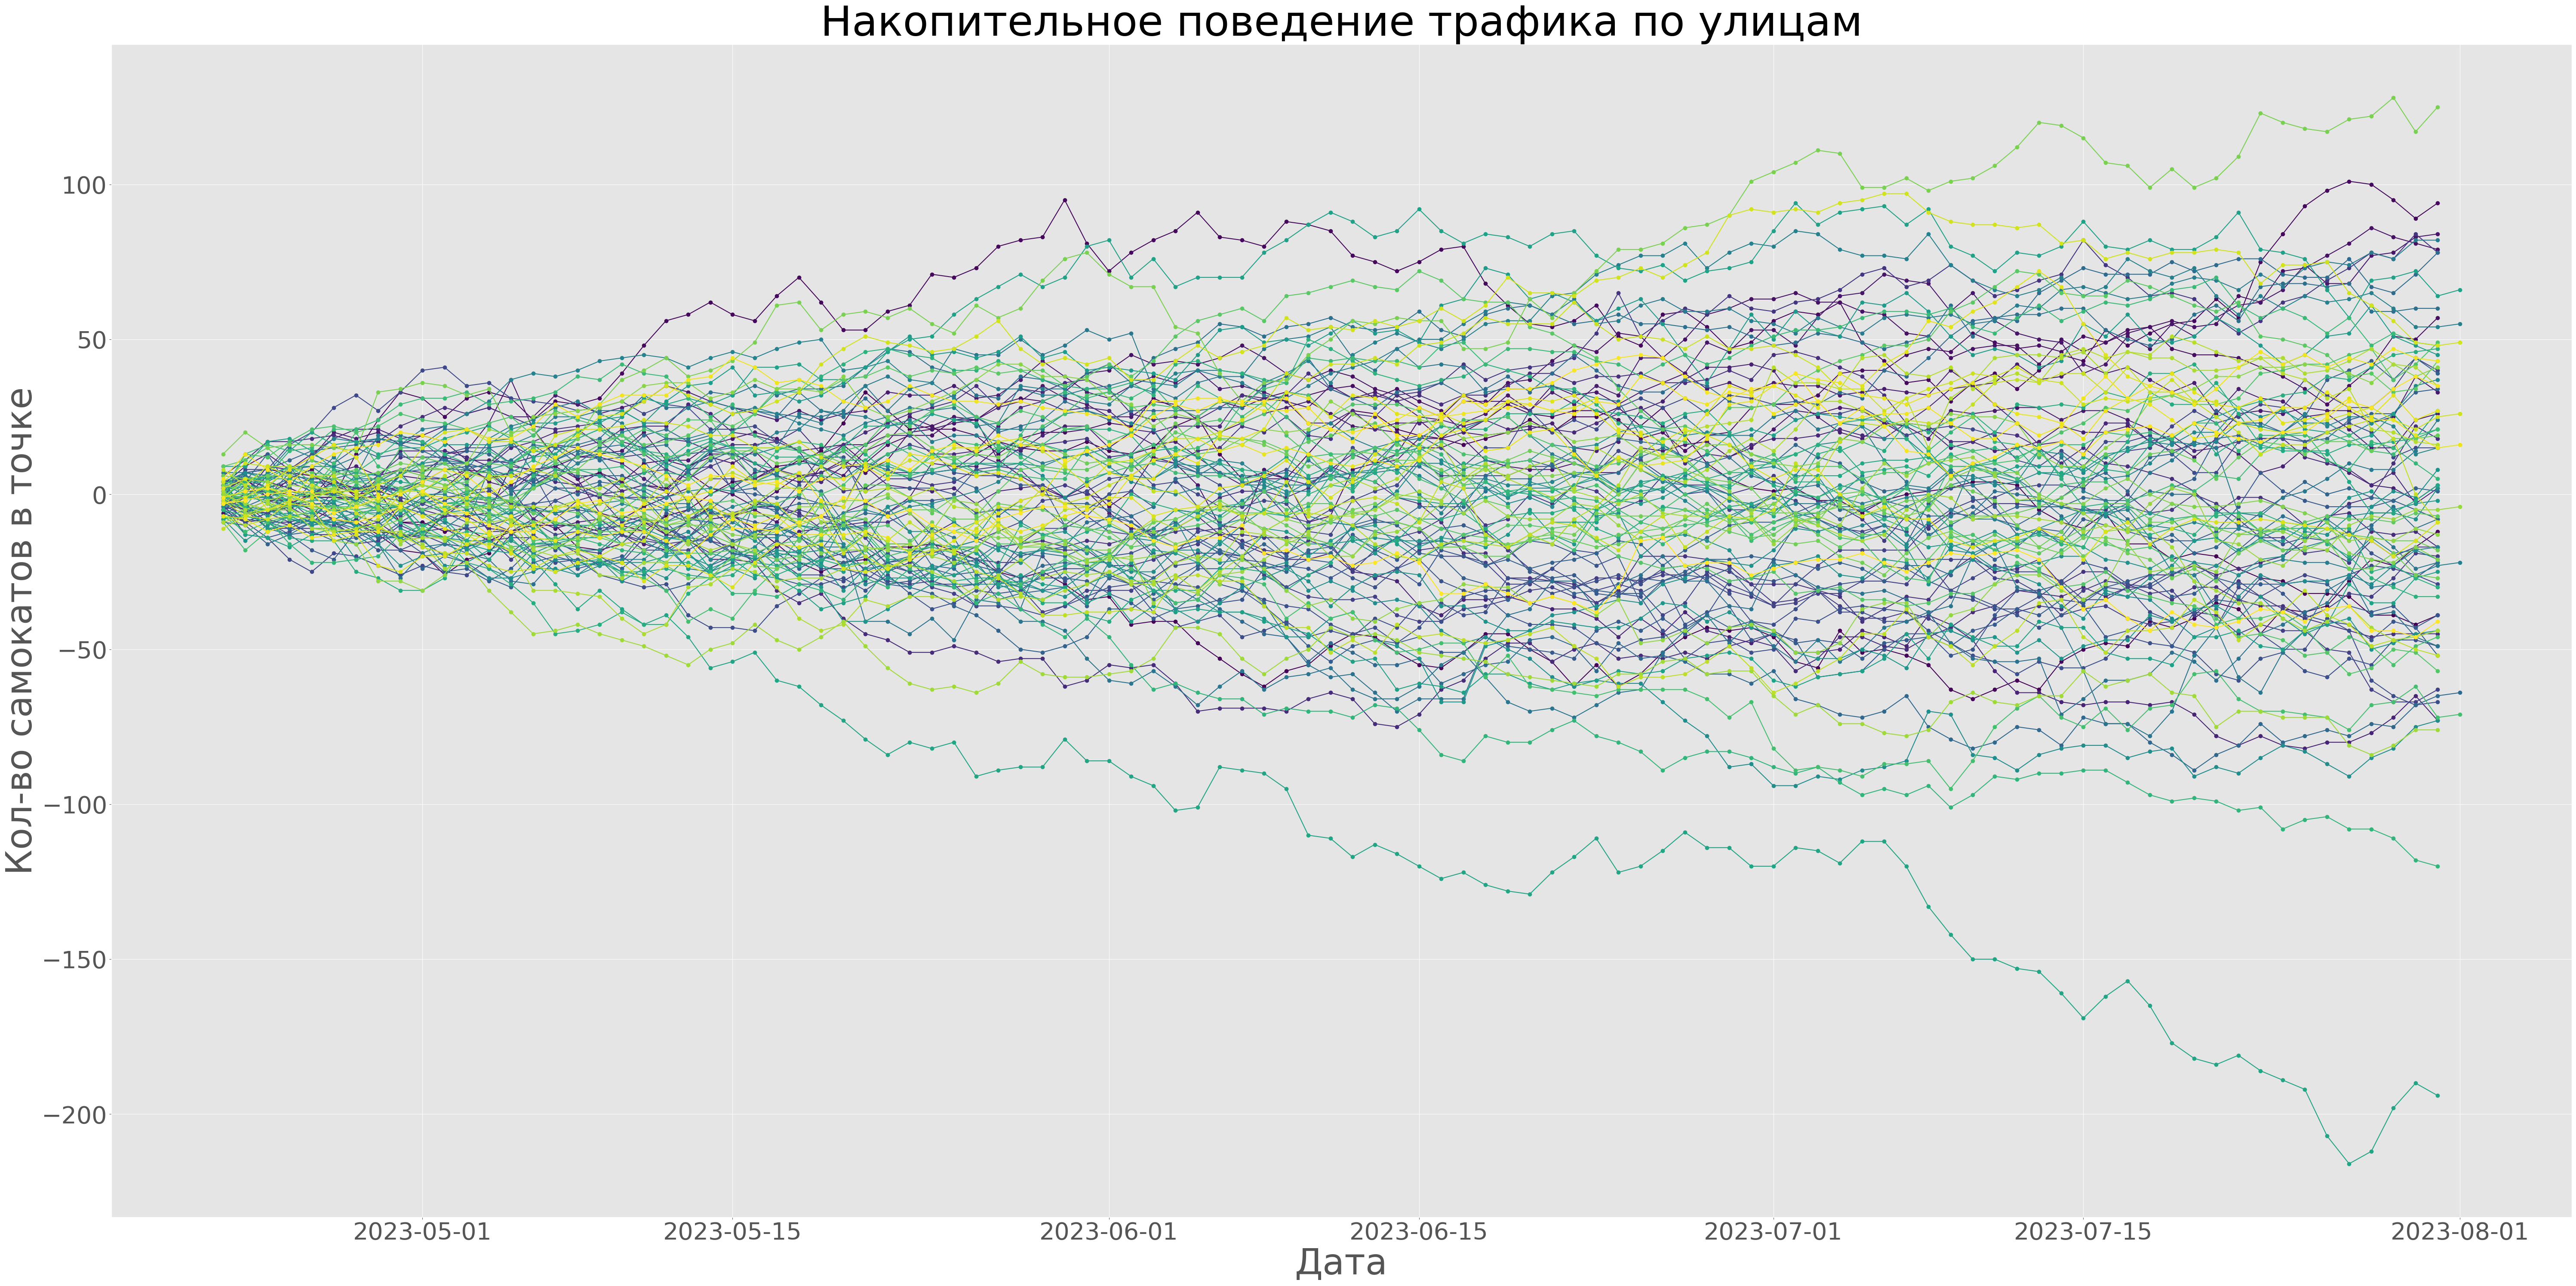

In [186]:
# Визуализация накопительного трафика
plt.figure(figsize=(60, 30))
plt.style.use('ggplot')
colors = plt.cm.viridis(np.linspace(0, 1, len(traffic_summary['location'].unique())))

for i, location in enumerate(traffic_summary['location'].unique()):
    subset = traffic_summary[traffic_summary['location'] == location]
    plt.plot(subset['date'], subset['cumulative_sum'], marker='o', label=location, color=colors[i])

plt.title('Накопительное поведение трафика по улицам', fontsize=70)
plt.xlabel('Дата', fontsize=60)
plt.ylabel('Кол-во самокатов в точке', fontsize=60)
plt.xticks(rotation=0, fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
# plt.legend(title='Локация', fontsize=15)
plt.tight_layout()

plt.show()

#### Вывод

На основании анализа можно сказать, что у некоторых точек количество самокатов колеблется в пределах 0 и не сильно отклоняется, их можно не трогать. Но есть группа отдельных улиц, которые стабильно теряют или переполучают самокаты. Из таких особенных улиц надо специально увозить или привозить самокаты.

### Общий вывод

1. Самый большой спрос на самокаты приходится на вечер с 17 до 22. Средняя стоимость зависит от тарифного плана.
2. Акция сильно влияет на спрос
3. Температура в первую очередь зависит от продолжительность солнечного сияния. Но так же от облачности, которая выступает как ограничивающий фактор для связи между.
4. Общее количество осадков зависит больше всего от облачности.
5. Скорость порывов ветра почти полностью зависят от скорости ветра.
6. Существуют супер-улицы с аномально большим трафиком

## Проверка гипотез

### 1. В дождливое время спрос на самокаты ниже?

H0: Между спросом на самокаты и дождливостью погоды <u>отсутствует</u> корреляция

H1: Между спросом на самокаты и дождливостью погоды <u>существует</u> корреляция

#### Подготовка данных

In [35]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)
    
print(f'Всего временных промежутков: {rides_df.shape[0]}')
print(f'Всего временных промежутков с дождём: {rides_df[rides_df['precipitation_total'] > 0].shape[0]}')
print(f'Всего временных промежутков с умеренным дождём и сильнее: {rides_df[rides_df['precipitation_total'] > 5].shape[0]}')

Всего временных промежутков: 3136
Всего временных промежутков с дождём: 516
Всего временных промежутков с умеренным дождём и сильнее: 1


Из открытых источников известно, что условно принято считать: 
* Cлабый дождь — 1–5 мм/ч 
* Умеренный — 5–20 мм/ч 
* Сильный — 20–40 мм/ч 
* Ливень — более 40 мм/ч 

В ходе подготовки данных о погоде выяснилось, что максимальное значение осадков не превышало 5.8 мм/ч и все дождливые дни, кроме одного, шёл слабый дождь. Поэтому в ходе анализа можно сделать только вывод на счёт слабого дождя. Имеющихся данных недостаточно, чтобы сказать о влиянии других типов дождя на спрос.

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

Сначала проверим влият ли <u>количество</u> осадков на спрос

In [36]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.009514361457735945 0.5943078140412971


Теперь проверим влият ли хотя бы какое-то <u>начилие</u> осадков на спрос. То есть теперь нас не волнует сколько было осадков. Нас интересует были ли они или нет.

In [38]:
# Переводим значения столбца в бинарный формат
rides_df['precipitation_total'] = rides_df['precipitation_total'].apply(lambda row: 1 if row > 0 else 0)

# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['precipitation_total'], rides_df['rides'])

print(k, p_value)

0.00853344772391502 0.6328699690146653


#### Вывод

В обоих расчётах значение коэффицента корреляции были близкими к нулю, а p-value были очень далеко от значения < 0.05. Поэтому мы принимаем H0. То есть погода не имеет никакого влияния на спрос на самокаты. Но стоит сказать, что речь идёт только о слабом дожде. То есть вывод таков: Слабый дождь не имеет никакого влияния на спрос на самокаты.

### 2. Отличается ли средняя стоимость поездки по районам?

H0: Средние стоимости поездок по районам <u>равны</u>

H1: Средние стоимости поездок по районам <u>отличаются</u>

#### Подготовка данных

При расчёте итоговой стоимости воспользуемся функцией calculate_income() из исследования 1

In [82]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Расчитываем итоговую стоимость
df = calculate_income(df)

#### Расчёты

Сначала через тест Шапиро-Уилка проверим данные на нормальность

In [83]:
# Проводим тест Шапиро-Уилка
_, p_value = shapiro(df['price'])

print(p_value.round(11))

0.0


Так как p-value < 0.05, то данные распределны ненормально и при расчёте корреляции мы будем использовать критерий Краскера-Уолса, так как групп у нас гораздо больше двух. Проверим зависит ли стоимость от района.

In [92]:
# Группируем по начальной и конечной локации
start_district_groups = df.groupby('start_district')['price'].apply(list)
end_district_groups = df.groupby('end_district')['price'].apply(list)

# Применяем критерий Краскера-Уолса
_, p_value_start = kruskal(*start_district_groups)
_, p_value_end = kruskal(*end_district_groups)

# Интерпретация результата
print(p_value_start < 0.05, p_value_end < 0.05)

True True


Дополнительно проведём графический анализ

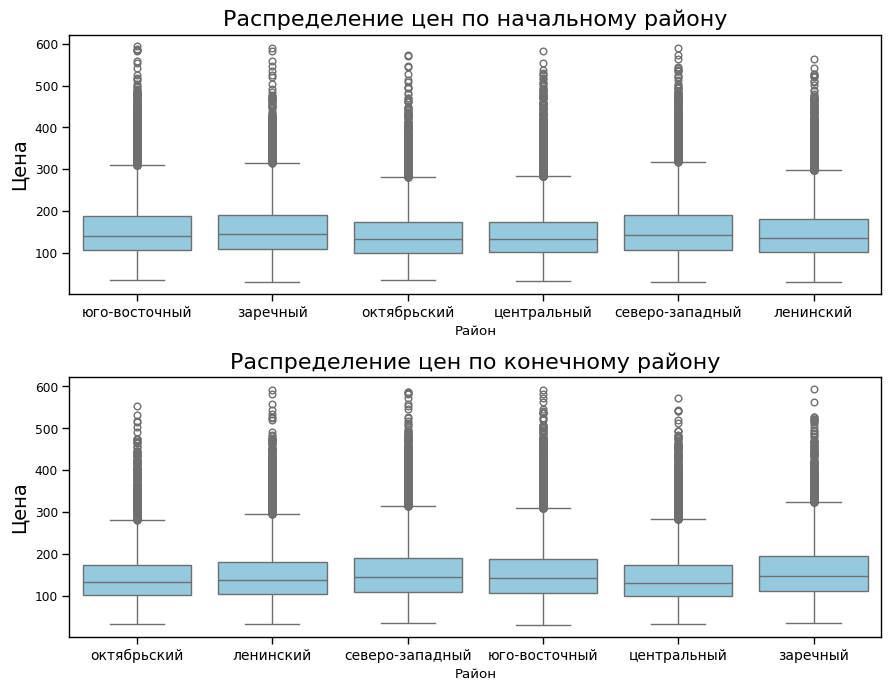

In [ ]:
# Создание графиков
fig, axes = plt.subplots(2, 1, figsize=(9, 7))

# Boxplot для начальной точке
sns.boxplot(x='start_district', y='price', data=df, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение цен по начальному району', fontsize=16)
axes[0].set_xlabel('Район')
axes[0].set_ylabel('Цена поездки', fontsize=14)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, fontsize=10)

# Boxplot для конечной точке
sns.boxplot(x='end_district', y='price', data=df, ax=axes[1], color='skyblue')
axes[1].set_title('Распределение цен по конечному району', fontsize=16)
axes[1].set_xlabel('Район')
axes[1].set_ylabel('Цена поездки', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, fontsize=10)

# Отображение графиков
plt.tight_layout()
plt.show()

Графически видно обратное - медианы цен почти равны. Проведём дополнительный анализ

In [ ]:
# Группируем по начальной и конечной локации
start_district_groups = df.groupby('start_district')['price']
end_district_groups = df.groupby('end_district')['price']

# Рассчитываем среднее и медиану
start_mean = start_district_groups.mean().round()
start_median = start_district_groups.median().round()

end_mean = end_district_groups.mean().round()
end_median = end_district_groups.median().round()

# Создаем датафрейм, где объединяем данные в единую таблицу для удобного выводы
summary_df = pd.DataFrame({
    'Start District Mean': start_mean,
    'End District Mean': end_mean,
    'Start District Median': start_median,
    'End District Median': end_median
}).fillna(0)

print("Среднее и медиана по начальным и конечным районам:")
print(summary_df)

Среднее и медиана по начальным и конечным районам:
                 Start District Mean  End District Mean  \
заречный                       157.0              160.0   
ленинский                      148.0              149.0   
октябрьский                    143.0              144.0   
северо-западный                157.0              158.0   
центральный                    144.0              142.0   
юго-восточный                  154.0              154.0   

                 Start District Median  End District Median  
заречный                         145.0                148.0  
ленинский                        136.0                137.0  
октябрьский                      132.0                134.0  
северо-западный                  144.0                145.0  
центральный                      134.0                131.0  
юго-восточный                    141.0                142.0  


Размах медиан и средних в среднем составляем порядка 15 рублей. Это довольно таки много. Вероятно, график создает ошибочное впечатление из-за слишком большого шага доходов.

#### Вывод

Оба значения p-value оказались меньше 0.05. После дополнительной проверки оказалось, что разница в средней цене поездки может доходить до 15 рублей. Можно вывод, что средняя стоимость поезки зависит от района, где была начала и закончена поездка, то есть H0 отвергается и остаётся альтернативная гипотеза H1.

Средние стоимости поездок по районам <u>отличаются</u>.

### 3. Спрос на самокаты меняется в зависимости от дня недели?

H0: Спрос на самокаты <u>одинаковый</u> в каждый день недели

H1: Спрос на самокаты <u>варьируется</u> в зависимости от дня недели

#### Подготовка данных

In [105]:
df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])

# Добавление столбца с днем недели
df['day'] = df['start_date'].dt.day_name()

# Подсчет количества поездок по дням недели
rides_per_day = df['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Группировка данных по дням недели и получение самих значений
grouped_data = [df[df['day'] == day]['id'].values for day in rides_per_day.index]

#### Расчёты

Сначала проведём графический анализ

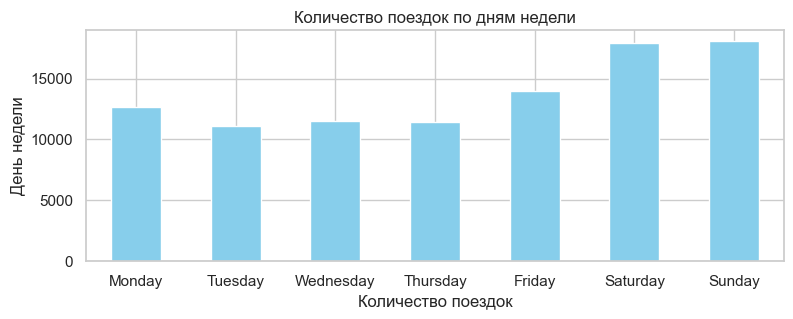

In [176]:
# Визуализация
plt.figure(figsize=(9, 3))
rides_per_day.plot(kind='bar', color='skyblue')
plt.title('Количество поездок по дням недели')
plt.xlabel('Количество поездок')
plt.ylabel('День недели')
plt.xticks(rotation=0)
plt.show()


Проверим данные на нормальность

In [177]:
results = {day: shapiro(data) for day, data in zip(rides_per_day.index, grouped_data)}

# Вывод результатов теста на нормальность
for day, (stat, p) in results.items():
    print(f"{day}, {p < 0.05}")

Monday, True
Tuesday, True
Wednesday, True
Thursday, True
Friday, True
Saturday, True
Sunday, True


Можно сделать вывод, что все данные распределны ненормально, следовательно мы будем использовать критерий Краскера-Уолса

In [178]:
# Проведение теста Краскала-Уоллиса
_, p_value = kruskal(*grouped_data)

print(p_value.round(20))

0.0


Судя по p-value, существует сильная зависимость между днём недели и спросом на самокаты. 

#### Вывод

Исходя из графического и анатитического анализа, получается, что зависимость существует и мы отвергает H0. То есть спрос на самокаты <u>зависит</u> от дня недели. Также стоит сказать, что самый сильный спрос по выходным, а самый низкий с вторника по четверг.

### 4. В выходные дни поездки более длинные

H0: Длительности поездок в выходные и будние дни <u>равны</u>

H1: Длительности поездок в выходные и будние дни <u>отличаются</u>

#### Подготовка данных

In [57]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Рассчитываем длительность поездки в минутах
df['time_delta'] = df['end_date'] - df['start_date']
df['time_delta'] = df['time_delta'].dt.seconds / 60

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о длительности поездки

In [58]:
_, p_value = shapiro(df['time_delta'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [59]:
# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['time_delta']
weekend_durations = df[df['is_weekend'] == True]['time_delta']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

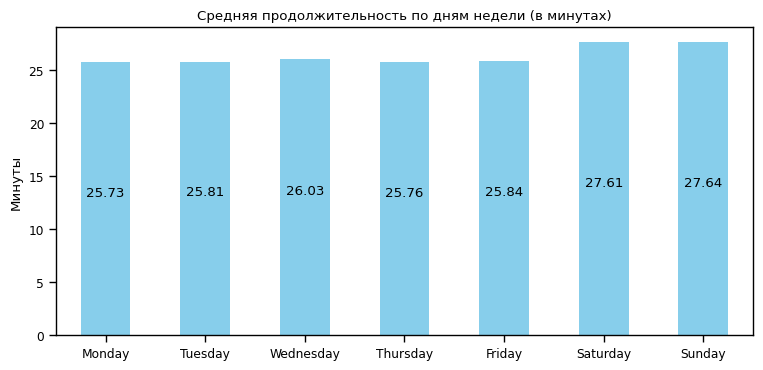

In [60]:
# Считаем средне время поездки и переводим его в минуты
mean_price_df = df.groupby(by=['day'])['time_delta'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

Графически действительно видно, что в выходные средняя длительности больше

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0. То есть длительности поездко в выходные и будние дни <u>отличаются</u>, а точнее в выходные дни поездки длиннее, чем в будние. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что хоть сильная зависимость и есть, но она средне сильно влият на среднюю длительность поездки. Разница между значениями в будние и выходные составляет примерно 7% (2 минуты).

### 5. В будние дни поездки более скоростные

H0: Скорости поездкок в выходные и будние <u>равны</u>

H1: Скорости поездкок в выходные и будние <u>отличаются</u>

#### Подготовка данных

In [106]:
df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])

# Создаем колонну ride_duration, которая содержит длительность поездки в минутах
df['ride_duration'] = (df.end_date - df.start_date).dt.seconds / 60 

# Создаем колонку average_speed, которая хранит среднюю скорость на протяжении всего пути в км/ч
df['average_speed'] = (df.distance / 1000) / (df.ride_duration / 60)

# Задаем порядок дней недели
df['day'] = df['start_date'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day'] = pd.Categorical(df['day'], categories=days_order, ordered=True)

#### Проверка корреляции

Сначала проверим с помощью теста Шапиро-Уилка, как распределены данные о средней скорости

In [107]:
_, p_value = shapiro(df['average_speed'])

print(p_value < 0.05)

True


Так как p-value < 0.05, то данные распределены ненормально и при расчёте корреляции мы будем использовать тест Манна-Уитни

In [108]:
# Создаем колонку для определения выходного или буднего дня
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday'])

# Разделяем данные на две группы
weekday_durations = df[df['is_weekend'] == False]['average_speed']
weekend_durations = df[df['is_weekend'] == True]['average_speed']

# Выполняем тест Манна-Уитни
_, p_value = mannwhitneyu(weekday_durations, weekend_durations)

# Выводим результаты
print(p_value < 0.05)

True


Действительно, так как p_value < 0.05, то корреляция существует

#### Графический анализ

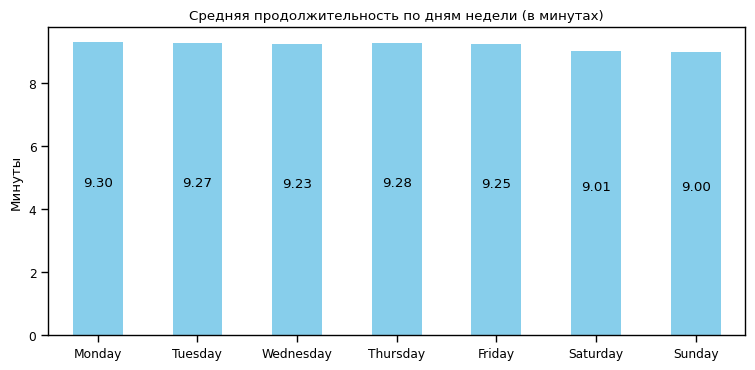

In [109]:
# Считаем средню скорость поездки
mean_price_df = df.groupby(by=['day'])['average_speed'].mean()

# Создаем график
plt.figure(figsize=(9, 4))
bars = mean_price_df.plot(kind='bar', color='skyblue')

# Подписываем бары с округлением до сотых
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() / 2, 
             f'{bar.get_height():.2f}',
             ha='center', 
             va='bottom')

plt.title('Средняя продолжительность по дням недели (в минутах)')
plt.xlabel('')
plt.ylabel('Минуты')
plt.xticks(rotation=0)
plt.show()

#### Вывод

Так как значение p_value < 0.05, то мы отвергаем H0. То есть скорость во время поездки <u>отчичается</u> в выходные и будние дни. Но также стоит сказать, что на основании графического анализа можно сделать вывод, что зависимость является обратной. То есть по выходным средняя скорость поездок наоборот меньше. Также стоит сказать, что в среднем значение скорости меняется не очень сильно, всего на 0.25 км/ч меньше по выходным.

### 6. Спрос зависит от температуры на улице

H0: Между температурой на улице и спросом на самокаты <u>отсутствует</u> корреляция

H1: Между температурой на улице и спросом на самокаты <u>существует</u> корреляция

#### Подготовка данных

In [57]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [58]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['temperature'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.338 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.338, что говорит о едва заметной связи между факторами.

#### Вывод

Спрос на самокаты очень слабо зависит от температуры на улице. А следовательно и солнечное сияние с облачностью не имеют даже слабого влияния на спрос(см. исследование 3).

### 7. Спрос зависит от скорости ветра на улице

H0: Между скоростью ветра на улице и спросом на самокаты <u>отсутствует</u> корреляция

H1: Между скоростью ветра на улице и спросом на самокаты <u>существует</u> корреляция

#### Подготовка данных

In [ ]:
rides_df = pd.read_csv('rides_&_weather.csv', parse_dates=['start_date', 'end_date', 'datetime'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Устанавливаем datetime как индекс
rides_df.set_index('datetime', inplace=True)

# Ресемплируем данные по часам и считаем количество поездок
counted_rides_df = rides_df.resample('H').size().reset_index(name='rides')

# Мержим таблицу погоды и трафика по часам
rides_df = pd.merge_asof(
    weather_df, 
    counted_rides_df, 
    left_on='datetime', 
    right_on='datetime',
    direction='backward'
)

# Удаляем пропуски(например, ночь, когда самокаты не берут в аренду)
rides_df = rides_df.dropna()
rides_df = rides_df[rides_df['rides'] > 0]

# Приводим значения в таблице к числовому формату
for col in rides_df.columns[1:]:
    rides_df[col] = rides_df[col].astype(float)

#### Расчёты

Из исследования 3(Исследование корреляцию между параметрами погодных условий) известно, что все данные о погоде распределены ненормально, следовательно при расчёте коэффицента корреляции будем использовать коэффицент корреляции Спирмена.

In [174]:
# Высчитываем значение корреляции
k, p_value = spearmanr(rides_df['wind_speed'], rides_df['rides'])

print(k.round(3), p_value < 0.05)

0.213 True


Хоть p_value < 0.05, значение коэффицента составляет всего 0.213, что говорит о том, что между факторами нет никакой связи.

#### Вывод

Спрос на самокаты <u>не зависит</u> от скорости ветра на улице

### Общий вывод

1. Спрос не зависит от дождя
2. Средние стоимости поездок по районам <u>отличаются</u>
4. Спрос на самокаты зависит от дня недели и выше всего в выходные
4. В выходные дли поездки более длинные
5. В будние дни поездки быстрыее, чем в выходные
6. Спрос на самокаты не зависит от температуры на улице
7. Спрос на самокаты не зависит от скорости ветра на улице

## Регрессионное моделирование

### Подготовка данных

In [290]:
rides_df = pd.read_csv('processed_rides.csv', parse_dates=['start_date', 'end_date'])
weather_df = pd.read_csv('processed_weather.csv', parse_dates=['datetime']).drop(index=0, axis=1)

# Новый df почасовых поездок во всех точках
rides_per_hour = rides_df.groupby(rides_df['start_date'].dt.round('h')).size().reset_index(name='rides')

rides_per_hour.rename(columns={'start_date': 'datetime'}, inplace=True)

# Обьединеям данные о почасовых поездках и погоде
df = pd.merge_asof(
    rides_per_hour, 
    weather_df, 
    on='datetime',
    direction='backward'
)

df.head()

datetime  rides temperature precipitation_total  wind_gust  \
0 2023-04-22 09:00:00     10   13.850245                 0.0      20.16   
1 2023-04-22 10:00:00     29   16.230246                 0.0       23.4   
2 2023-04-22 11:00:00     38   17.080246                 0.1  41.760002   
3 2023-04-22 12:00:00     35   18.130245                 0.0  29.519999   
4 2023-04-22 13:00:00     42   18.370245                 0.0  20.880001   

  wind_speed cloud_cover_total sunshine_duration  
0  6.2145634              71.0         16.969696  
1   5.815978              88.0          6.666666  
2   8.699793              94.0         3.0303025  
3  10.685391              22.2         46.545456  
4  15.782622              38.0         36.969692

### Создание новых признаков и определение факторов

После проведения исследований и проверки гипотез мы выделели основные факторы, которые оказывают влияние на спрос самокатов. К ним относятся:
* Время (в часах)
* День недели
* Выходной ли день
* Вечер ли
* Утро ли
* Проведена ли акция

Так же добавим лаговые факторы ( на час и на день) и среднее значение поздок за 3 часа

In [291]:
# Добавляем новые факторы
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_of_week + 1

df['is_promo_time'] = df['day_of_week'] == 1 & df['hour'].between(6, 9)
df['is_weekend'] = df['day_of_week'] >= 6
df['is_evening'] = df['hour'].between(16, 21)
df['is_morning'] = df['hour'].between(6, 10)

# Лаговые значения спроса
df['lag_1'] = df['rides'].shift(1) # Лаг на час
df['lag_24'] = df['rides'].shift(24)  # Лаг на день

# Средние значения поездок за последние 3 часа
df['rides_mean_3h'] = df['rides'].shift(1).rolling(window=3).mean()

# Удаляем строки с NaN, которые появились из-за сдвига
df.dropna(inplace=True)

# Используем one hot encoder для часа и дня недели, т.к. это категориальные признаки
OHE = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' для избежания мультиколлинеарности

# Применяем OHE к hour и day_of_week
encoded_features = OHE.fit_transform(df[['hour', 'day_of_week']])

# Создаем DataFrame с закодированными признаками
encoded_df = pd.DataFrame(encoded_features, columns=OHE.get_feature_names_out(['hour', 'day_of_week']))

# Объединяем закодированные признаки с оригинальным DataFrame
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Удаляем старые категориальные столбцы
df.drop(columns=['hour', 'day_of_week'], inplace=True)

df.head()

datetime  rides temperature precipitation_total  wind_gust  \
0 2023-04-23 09:00:00     25   15.190246                 0.0       19.8   
1 2023-04-23 10:00:00     32   16.240246                 0.2  22.319998   
2 2023-04-23 11:00:00     30   17.380245                 0.2      42.12   
3 2023-04-23 12:00:00     34   18.580246                 0.2  51.839996   
4 2023-04-23 13:00:00     54   19.450245                 0.0      52.56   

  wind_speed cloud_cover_total sunshine_duration  is_promo_time  is_weekend  \
0  7.6367526              29.7              42.0          False        True   
1        7.2              39.0          36.36364          False        True   
2  11.720751              72.0         16.363636          False        True   
3  14.417988              76.0         13.939394          False        True   
4  14.759999              53.0         27.878788          False        True   

   ...  hour_20  hour_21  hour_22  hour_23  day_of_week_2  day_of_week_3  \
0  ...      0.0      0.0      0.0      0.0            0.0            0.0   
1  ...      0.0      0.0      0.0      0.0            0.0            0.0   
2  ...      0.0      0.0      0.0      0.0            0.0            0.0   
3  ...      0.0      0.0      0.0      0.0            0.0            0.0   
4  ...      0.0      0.0      0.0      0.0            0.0            0.0   

   day_of_week_4  day_of_week_5  day_of_week_6  day_of_week_7  
0            0.0            0.0            0.0            1.0  
1            0.0            0.0            0.0            1.0  
2            0.0            0.0            0.0            1.0  
3            0.0            0.0            0.0            1.0  
4            0.0            0.0            0.0            1.0  

[5 rows x 44 columns]

### Тренировка модели

In [292]:
X = df.drop(columns=['datetime', 'rides'])
y = df['rides']

# Разделяем данные для анализа
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Шаг 2: Обучение модели линейной регрессии
model = LinearRegression()

# Обучение на всех тренировочных данных
model.fit(X_train, y_train)
print('')

### Проверка работы

In [293]:
# Прогнозирование
y_pred = model.predict(X_test).round().astype(int)

# Обработка отрицательных значений (если такие появляются)
y_pred = np.maximum(y_pred, 0)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод интерпретации результатов
print(f"=== Результаты оценки модели ===")
print(f"MSE (Mean Squared Error): {mse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² (R-squared): {r2:.2f}")

=== Результаты оценки модели ===
MSE (Mean Squared Error): 110.88
MAE (Mean Absolute Error): 7.98
R² (R-squared): 0.89


### Визуализация результата работы модели

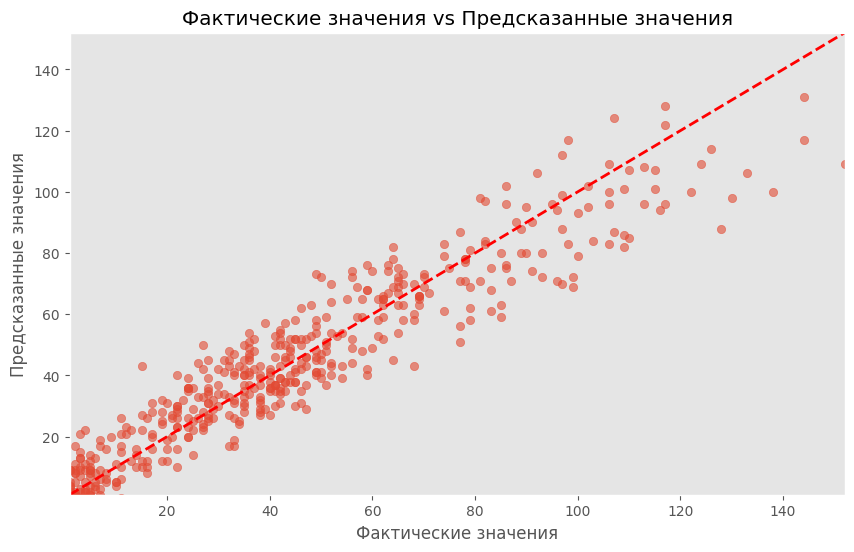

In [294]:
# График рассеяния: фактические значения против предсказанных
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Линия y=x
plt.title('Фактические значения vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()
